## superresolution
single image superresolution (4x zoom)
- channel attention mechanism [[paper]](https://arxiv.org/abs/1807.02758)
- residual in residual architecture [[paper]](https://arxiv.org/abs/1505.04597)
- subpixel convolution / pixelshuffle [[paper]](https://arxiv.org/abs/1609.05158)
- running on [tensorflow/google colab](https://colab.research.google.com/) AND on [plaidml](https://www.intel.ai/plaidml/)
- using the famous [Set14](https://www.google.com/search?q=set14) dataset ONLY (with heavy augmentation) - no validation needed

jupyter notebook by [Benjamin Wegener](https://scholar.google.de/citations?user=yEn9St8AAAAJ) from [github](https://www.github.com/BenjaminWegener/keras-examples)

### options


In [0]:
run_on_google_colab = True #use PlaidML as Backend, change this to 'True' to run on colab/tf
epochs = 25 #Number of epochs to train
scale = 4 #How much should we upscale images
channels = 3 #channels of low resolution image
batch_size = 14 #what batch-size should we use (decrease if you encounter video memory errors)
steps_per_epoch = 1000 #How much iterations per epoch to train
height_lr = 64 #height of low resolution image
width_lr = height_lr #width of low resolution image
gen_lr = 0.001 #learning rate of generator
logging_steps = 200 #how often to update the training log
height_hr = int(height_lr * scale) # High-resolution image height
width_hr = int(width_lr * scale) # High-resolution image width

### imports

In [0]:
import os
if run_on_google_colab:
    %cd /content
    !git clone https://github.com/BenjaminWegener/keras-examples #download Dataset
    %cd keras-examples
else:
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import numpy as np
from keras.models import Model, Input, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import *
from keras import backend as K
from keras.callbacks import LambdaCallback
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
%matplotlib inline    

/content
fatal: destination path 'keras-examples' already exists and is not an empty directory.
/content/keras-examples


### function for image visualization

In [0]:
def show(tensors):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    for i in range(len(tensors)):
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 0)
        except:
            pass
        tensors[i] = (tensors[i] + 1.) * 127.5
        fig.add_subplot(1,len(tensors), i + 1)
        plt.imshow(tensors[i].astype(np.uint8), interpolation = 'nearest')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

### dataset function

In [0]:
# return batch of augmented train and target images with quantity n_samples
def get_batch(n_samples, height, width, channels):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range=360,
                           width_shift_range=0.5,
                           height_shift_range=0.5,
                           zoom_range=[0.2, 0.7],
                           horizontal_flip=True,
                           vertical_flip=True,
                           fill_mode='reflect',
                           data_format='channels_last',
                           brightness_range=[0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    y_train = image_gen.flow_from_directory('.', target_size = (height * scale, width * scale), batch_size = n_samples, class_mode = None, seed = random_seed)
    y_train = y_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
    x_train = np.empty((len(y_train), height, width, channels))
    for i in range(n_samples):
        # source images are zoomed to 25%
        input_size = height * scale
        output_size = height
        fraction = input_size // output_size
        x_train[i] = y_train[i].reshape((output_size, fraction, output_size, fraction, channels)).mean(3).mean(1)
    #normalize images to [-1, 1]
    x_train = x_train/127.5 - 1.
    y_train = y_train/127.5 - 1.
    return x_train, y_train

### loss function

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
#vgg = VGG16(include_top=False, weights='imagenet', input_shape=(height_lr, width_lr, 3))
perceptual_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(height_lr, width_lr, 3)) 
#perceptual_model = VGG16(include_top=False, weights='imagenet', input_shape=(height_lr, width_lr, 3)) 
#loss_model = Model(inputs=vgg.input, outputs=[vgg.get_layer('block1_conv2').output, vgg.get_layer('block3_conv3').output, vgg.get_layer('block5_conv3').output]) 
#perceptual_model.summary()
loss_model = Model(inputs=perceptual_model.input, outputs=[perceptual_model.get_layer('block_3_project').output, perceptual_model.get_layer('block_6_project').output, perceptual_model.get_layer('block_9_project').output]) 
#loss_model = Model(inputs=perceptual_model.input, outputs=[perceptual_model.get_layer('block1_conv2').output, perceptual_model.get_layer('block3_conv3').output, perceptual_model.get_layer('block5_conv3').output]) 

loss_model.trainable = False

def perceptual_loss(y_true, y_pred):    
    loss = 0
    true1, true2, true3 = loss_model(y_true)
    pred1, pred2, pred3 = loss_model(y_pred)
#    true = loss_model(y_true)
#    pred = loss_model(y_pred)
    
#    loss += K.mean(K.abs(true - pred))
    loss += K.mean(K.abs(pred1 - true1))
    loss += K.mean(K.abs(pred2 - true2))
    loss += K.mean(K.abs(pred3 - true3))
    loss /=  3
    #loss += K.mean(K.abs(y_pred - y_true))
    loss *= K.sqrt(K.sum(K.abs(y_true - y_pred)))
    #loss /= 2
    return loss

def vgg_loss(y_true, y_pred):    
    loss = 0
#    true1, true2, true3 = loss_model(y_true)
#    pred1, pred2, pred3 = loss_model(y_pred)
    true = loss_model(y_true)
    pred = loss_model(y_pred)
    
    loss += K.mean(K.square(true - pred))
#    loss += K.mean(K.square(true1 - pred1))
#    loss += K.mean(K.square(true2 - pred2))
#    loss += K.mean(K.square(true3 - pred3))
#    loss /=  3
    loss *= K.sum(K.abs(y_true - y_pred))
    
    return loss

def multiscale_loss(y_true, y_pred):
    loss = 0
    for row in range(K.int_shape(y_pred)[1]):
        true_slice = K.slice(y_true, [0, 0, row, 0], [-1, -1, 1, -1])
        pred_slice = K.slice(y_pred, [0, 0, row, 0], [-1, -1, 1, -1])
        difference = K.sum(K.abs(true_slice - pred_slice))
        variance = K.sum(K.abs((K.max(true_slice) - K.min(true_slice)) - (K.max(pred_slice) - K.min(pred_slice))))
        loss += (difference + variance) / 2
    for column in range(K.int_shape(y_pred)[1]):
        true_slice = K.slice(y_true, [0, column, 0, 0], [-1, -1, 1, -1])
        pred_slice = K.slice(y_pred, [0, column, 0, 0], [-1, -1, 1, -1])
        difference = K.sum(K.abs(true_slice - pred_slice))
        variance = K.sum(K.abs((K.max(true_slice) - K.min(true_slice)) - (K.max(pred_slice) - K.min(pred_slice))))
        loss += (difference + variance) / 2
    return loss

def custom_loss(y_true, y_pred):
    return (multiscale_loss(y_true, y_pred) * vgg_loss(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### base functions

In [0]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)

def residual_block(inputs, filters, kernel_size): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(filters, kernel_size = kernel_size, activation = 'tanh', padding = 'same', strides = 2)(x)
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, filters))(x)
    x = Conv1D(filters, kernel_size = 2, activation = 'sigmoid', padding = 'same')(x) #reduction like in RCAN 
    x = Multiply()([x1, x])
    x = Conv2DTranspose(3, kernel_size = kernel_size, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Add()([inputs, x]) 
    x = fast_normalization(x)
    return x

def upsample(inputs, filters, kernel_size): #combined pixel shuffle and squeeze with 2x upscale
    x = inputs
    x = Conv2D(filters, kernel_size = kernel_size, activation = 'tanh', padding = 'same', strides = 1)(x)
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, filters))(x)
    x = Conv1D(filters, kernel_size = 2, activation = 'sigmoid', padding = 'same')(x) #reduction like in RCAN 
    x = Multiply()([x1, x])
    x = Conv2DTranspose(3, kernel_size = kernel_size, activation = 'tanh', padding = 'same', strides = 2)(x)
    #x = Add()([inputs, x]) 
    x = fast_normalization(x)
    return x


### build generator model

In [0]:
x = inputs = Input(shape = (height_lr, width_lr, channels))
x = residual_block(x, 9, 8)
x = residual_block(x, 5, 16)
x = residual_block(x, 3, 24)
x = residual_block(x, 2, 32)
x = upsample(x, 9, 24)
x = upsample(x, 3, 8)

generator = Model(inputs = inputs, outputs = x)
#generator.summary()

### train

epoch 25 / 25 --> step 800 / 1000 : loss 100.57161712646484


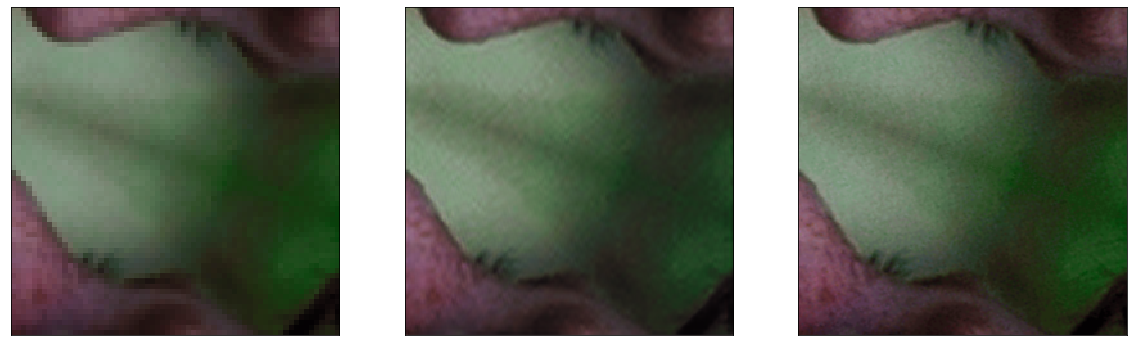

test_loss: 24.093212127685547
trying to save weights... 

In [32]:
#load checkpoint & compile the generator network
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('superresolution_weights')
    print('success.')
except:
    print('failed')
    pass

generator.compile(optimizer = Adam(gen_lr), loss = perceptual_loss)
#generator.compile(optimizer = Adam(gen_lr), loss = 'mae')

# Train generator
def logging(epoch, logs):
    if epoch % logging_steps == 0:
        testX, testY = get_batch(1, height_lr, width_lr, channels)
        clear_output()
        print('epoch', real_epoch + 1, '/', epochs, '--> step', epoch, '/', steps_per_epoch, ': loss', logs['loss'])
        testZ = generator.predict(testX)
        show([testX, testZ, testY])
        print('test_loss:', generator.evaluate(testX, testY, verbose = 0))
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: logging(epoch, logs)
)
for real_epoch in range(epochs):
    X, Y = get_batch(batch_size, height_lr, width_lr, channels)
    generator.fit(X, Y, batch_size, epochs = steps_per_epoch, verbose = 0, callbacks = [logging_callback], shuffle = True)
    try:
        print('trying to save weights...', end = ' ')
        generator.save_weights('superresolution_weights')
    except:
        print('failed.')

### validate on complete picture

In [0]:
# show image in actual size https://stackoverflow.com/a/42314798/
def display_image_in_actual_size(im_data):
    dpi = 100
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

In [0]:
from PIL import Image
img = np.array(Image.open('./Set14/lenna.png'))
img = img /127.5 -1
x = inputs = Input(shape = img.shape)
x = Conv2D(32, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)
x = upsample(x)
x = upsample(x)
generator = Model(inputs = inputs, outputs = x)
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('superresolution_weights')
    print('success.')
except:
    print('failed')
    pass
predicted = generator.predict(np.expand_dims((img), 0))
print('ground truth:')
img = (img + 1) * 127.5
display_image_in_actual_size(img.astype(np.uint8))
print('superresolution:')
predicted = np.squeeze(predicted)
predicted = (predicted + 1) * 127.5
display_image_in_actual_size(predicted.astype(np.uint8))
predicted = Image.fromarray(predicted.astype(np.uint8))
print('trying to save image as \'superresolution_result.png\'...', end = ' ')
try:
    predicted.save('superresolution_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass

TypeError: ignored